Load data for network from file

In [121]:
import tensorflow as tf
from sklearn.metrics import confusion_matrix
from pprint import pprint
from tensorflow.examples.tutorials.mnist import input_data
import numpy as np
import matplotlib.pyplot as plt
import json
%matplotlib inline


In [122]:
wine = np.genfromtxt("datasets/wine/wine_train_array.csv", delimiter=',')


In [123]:
wine[0]

array([0.59210526, 0.17786561, 0.79569892, 0.25257732, 0.43478261,
       0.55862069, 0.68823529, 0.42      , 0.29746835, 0.28327645,
       0.49593496, 0.56981132, 0.48666128, 1.        , 0.        ,
       0.        ])

In [124]:
X = wine[:,:-3]
Y = wine[:,-3:]

In [125]:
X[0]

array([0.59210526, 0.17786561, 0.79569892, 0.25257732, 0.43478261,
       0.55862069, 0.68823529, 0.42      , 0.29746835, 0.28327645,
       0.49593496, 0.56981132, 0.48666128])

In [126]:
Y[0]

array([1., 0., 0.])

In [127]:
#train_x,train_y,test_x,test_y = create_feature_sets_and_labels('Data/pos.txt','Data/neg.txt')
train_x = X
train_y = Y



In [128]:
class TfAnn(object):
    
    def __init__(self):
        self.hidden=[]
        self.np_hidden=[]
        
        self.n_nodes=[]
        self.n_classes = 0
        self.n_hiden_layers = 0

    
    def init_empty(self,layers,n_classes,size):
        self.n_classes = n_classes
        self.n_hiden_layers = len(layers)
        for i in range(self.n_hiden_layers):
            self.hidden.append({'weights':[],'biases':[]})
            self.np_hidden.append({'weights':[],'biases':[]})
            self.n_nodes.append(layers[i])
        self.output_layer = {'weights':[],'biases':[]}
        self.np_output_layer={"weights":[],"biases":[]}

        for i in range(self.n_hiden_layers):
            self.hidden[i] = {'weights':tf.Variable(tf.random_normal([size, self.n_nodes[i]])),
                      'biases':tf.Variable(tf.random_normal([self.n_nodes[i]]))}
            
        self.output_layer = {'weights':tf.Variable(tf.random_normal([self.n_nodes[-1], self.n_classes])),
                        'biases':tf.Variable(tf.random_normal([self.n_classes]))}


    def init_json(self,tf_json):
        tf_data = json.loads(tf_json)
        self.n_classes = tf_data["n_classes"]
        self.n_hiden_layers = tf_data["n_hiden_layers"]
        self.hidden =tf_data["hidden"]
        self.output_layer =tf_data["output"]


    def create(self,data):
        # This is the heart of the ann where multiply the data by the wights to the layers 
        for i in range(self.n_hiden_layers):
            layer = tf.add(tf.matmul(data,self.hidden[i]['weights']), self.hidden[i]['biases'])
            layer= tf.nn.relu(layer)
        output =  tf.add(tf.matmul(layer,self.output_layer['weights']) , self.output_layer['biases'])
        return output
    
    def extract(self):
        for i in range(self.n_hiden_layers):
            self.np_hidden[i]["weights"] = neural_network_model.hidden[i]["weights"].eval().tolist()
            self.np_hidden[i]["biases"] = neural_network_model.hidden[i]["biases"].eval().tolist()
        self.np_output_layer["weights"] = neural_network_model.output_layer["weights"].eval().tolist()
        self.np_output_layer["biases"] = neural_network_model.output_layer["biases"].eval().tolist()
        return json.dumps({"n_classes":self.n_classes,"n_hiden_layers":self.n_hiden_layers ,"hidden":self.np_hidden,"output":self.np_output_layer}, ensure_ascii=False)
        
        

In [129]:
def train_neural_network_interactive(neural_network_model,x_data_train,y_data_train,x_data_test,y_data_test):
    x = tf.placeholder('float')
    y = tf.placeholder('float')
    prediction = neural_network_model.create(x)
    cost = tf.reduce_mean( tf.nn.softmax_cross_entropy_with_logits(logits=prediction, labels=y) )
    optimizer = tf.train.AdamOptimizer().minimize(cost)
    hm_epochs = 2500
    sess = tf.InteractiveSession()
    init = tf.initialize_all_variables()
    sess.run(init)
    losses=[]
    for epoch in range(hm_epochs):
            _, c = sess.run([optimizer, cost], feed_dict={x:x_data_train,
                                                          y:y_data_train})
            losses.append(c)

    y_test_res=(sess.run(prediction,feed_dict={
                             x:x_data_test
                              }))       
    
    true_class=np.argmax(y_data_test,1)
    predicted_class=np.argmax(y_test_res,1)
    return confusion_matrix(predicted_class,true_class),losses
   

In [130]:
from sklearn.model_selection import StratifiedKFold
train_index=[]
test_index=[]
splits =5
skf = StratifiedKFold(n_splits=splits,random_state=0,shuffle=True)
for train_idx, test_idx in skf.split(train_x,train_y[:,0]):               
    train_index.append(train_idx)
    test_index.append(test_idx)

/home/ric/Projects/Python/env/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


array([[10,  0,  0],
       [ 0, 12,  0],
       [ 0,  0,  7]])


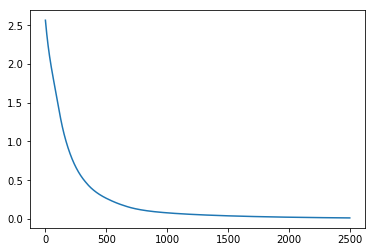

array([[10,  0,  0],
       [ 0,  8,  0],
       [ 0,  0, 11]])


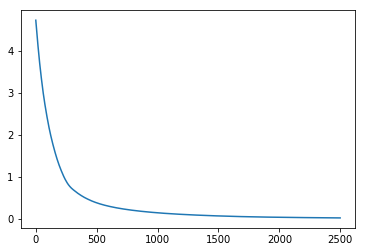

array([[ 9,  2,  0],
       [ 0, 11,  0],
       [ 0,  0,  6]])


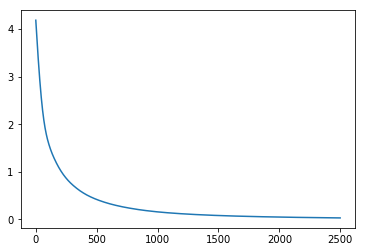

array([[ 9,  1,  0],
       [ 0, 10,  0],
       [ 0,  0,  8]])


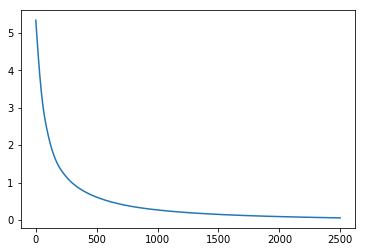

array([[ 9,  0,  0],
       [ 0, 13,  0],
       [ 0,  0,  6]])


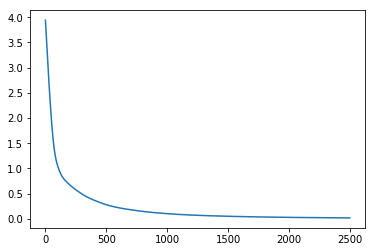

In [131]:
for fold in range(splits):
    neural_network_model = TfAnn()
    neural_network_model.init_empty([13],len(train_y[0]),len(train_x[0]))
    x_data_train = train_x[train_index[fold]]
    y_data_train = train_y[train_index[fold]] 
    x_data_test = train_x[test_index[fold]]
    y_data_test = train_y[test_index[fold]]
    cf,loss = train_neural_network_interactive(neural_network_model,x_data_train,y_data_train,x_data_test,y_data_test)
    pprint(cf)
    plt.plot(loss)
    plt.show()

array([[47,  0,  0],
       [ 0, 57,  0],
       [ 0,  0, 38]])


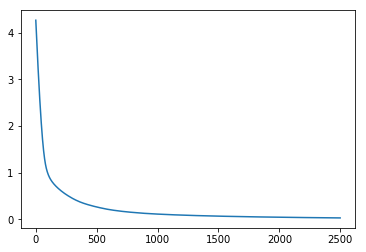

In [132]:
neural_network_model = TfAnn()
neural_network_model.init_empty([13],len(train_y[0]),len(train_x[0]))
x_data_train = train_x
y_data_train = train_y
x_data_test = train_x
y_data_test = train_y
cf,loss = train_neural_network_interactive(neural_network_model,x_data_train,y_data_train,x_data_test,y_data_test)
pprint(cf)
plt.plot(loss)
plt.show()

In [133]:
tf_json = neural_network_model.extract()

In [134]:
pprint(tf_json)

('{"n_classes": 3, "n_hiden_layers": 1, "hidden": [{"weights": '
 '[[-0.6747685670852661, -1.0129708051681519, 0.07212898880243301, '
 '-0.6548081040382385, 1.7981441020965576, -0.3317052721977234, '
 '1.9922807216644287, -0.6728514432907104, 0.7882229089736938, '
 '-0.3577181100845337, 0.20357367396354675, 0.27008095383644104, '
 '-2.889350175857544], [-0.036357227712869644, -0.30494424700737, '
 '-0.5950943231582642, -2.0209920406341553, 1.3817710876464844, '
 '1.1033978462219238, 0.646893322467804, 0.04635380581021309, '
 '0.7701341509819031, -0.2708803713321686, 0.617526113986969, '
 '1.437685251235962, -1.0559568405151367], [-0.7639071941375732, '
 '-0.16440702974796295, -0.23462910950183868, -0.40433448553085327, '
 '0.44294434785842896, -0.1271151304244995, 0.10048075020313263, '
 '0.09910881519317627, 0.7061432600021362, 0.4147971570491791, '
 '-1.2173278331756592, 1.3012162446975708, 1.9694225788116455], '
 '[-1.0822316408157349, -1.0249876976013184, -2.188617706298828, '
 '1.

In [136]:
neural_network_model = TfAnn()
neural_network_model.init_json(tf_json)
pprint(neural_network_model.extract())
#x_data_train = train_x
#y_data_train = train_y
#x_data_test = train_x
#y_data_test = train_y
#cf,loss = train_neural_network_interactive(neural_network_model,x_data_train,y_data_train,x_data_test,y_data_test)
#pprint(cf)
#plt.plot(loss)
#plt.show()

AttributeError: 'list' object has no attribute 'eval'